In [1]:
import os
import numpy as np

import scipy as sp
from scipy import stats
from numpy.matlib import repmat 
from scipy.linalg import svd, schur

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
from matplotlib.ticker import FormatStrFormatter

Functions

In [2]:
def node_strength(A):
    s = np.sum(A, axis = 0)

    return s

def node_degree(A):
    B = A > 0
    k = np.sum(B, axis = 0)
    
    return k

def ave_control(A, c = 0.99):
    # Bassett Lab, University of Pennsylvania, 2016.
    # Reference: Gu, Pasqualetti, Cieslak, Telesford, Yu, Kahn, Medaglia,
    #            Vettel, Miller, Grafton & Bassett, Nature Communications
    #            6:8414, 2015.

    u, s, vt = svd(A) # singluar value decomposition
    A = (A/s[0])*c # Matrix normalization
    T, U = schur(A,'real') # Schur stability
    midMat = np.multiply(U,U).transpose()
    v = np.matrix(np.diag(T)).transpose()
    N = A.shape[0]
    P = np.diag(1 - np.matmul(v,v.transpose()))
    P = repmat(P.reshape([N,1]), 1, N)
    ac = sum(np.divide(midMat,P))
    
    return ac

In [3]:
# output directory
figdir = '/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis_int/t1Exclude/schaefer_200_streamlineCount_consist/figs'
os.chdir(figdir)

In [4]:
# set seaborn figure style
sns.set(style='white', context = 'talk', font_scale = 1)

### Generate toy network

In [5]:
num_nodes = 5
np.random.seed(5)

A = np.random.randint(0, 50, size = [num_nodes,num_nodes])
A = A + A.transpose()
A[np.eye(num_nodes) == 1] = 0

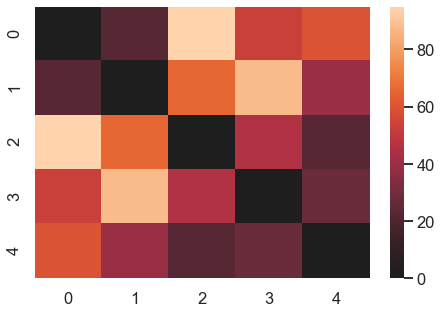

In [6]:
f, ax = plt.subplots()
f.set_figwidth(7.5)
f.set_figheight(5)
sns.heatmap(A, center = 0, ax = ax)

### Calculate strength, degree, and average control on toy network

In [7]:
node_strength(A)[0]

231

In [8]:
node_degree(A)[0]

4

In [9]:
ave_control(A)[0]

12.416327267034728

### Run simple simulation of the linear system to illustrate the impulse response

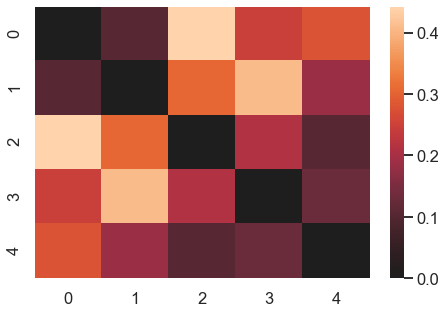

In [10]:
# Normalize A matrix and plot
c = 0.99 # designate scaling factor
u, s, vt = svd(A) # SVD
A_norm = (A/s[0])*c # Matrix normalization

f, ax = plt.subplots()
f.set_figwidth(7.5)
f.set_figheight(5)
sns.heatmap(A_norm, center = 0, ax = ax)

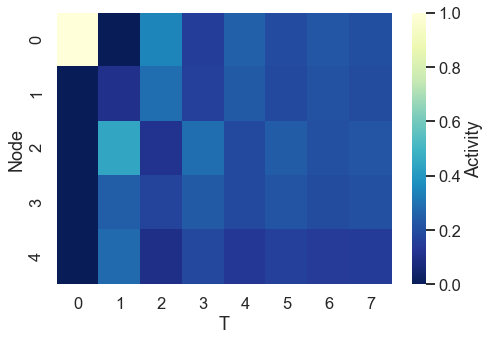

In [11]:
# Simulate linear system
num_steps = 8
x = np.zeros((num_nodes,num_steps))
x[0,0] = 1 # set region 0 to be 'on' at T 0
for t in np.arange(1,num_steps): # run simulation of linear system
    x[:,t] = np.dot(A_norm,x[:,t-1])

f, ax = plt.subplots()
f.set_figwidth(7.5)
f.set_figheight(5)
sns.heatmap(x, ax = ax, cmap = 'YlGnBu_r', cbar_kws={'label': 'Activity'})
ax.set_xlabel('T')
ax.set_ylabel('Node')
f.savefig('YlGnBu_r_full.svg', dpi = 300, bbox_inches = 'tight')

### Lesion A matrix and re do simulation

In [12]:
A_lesioned = A.copy()
A_lesioned[2,1] = 0
A_lesioned[1,2] = 0
A_lesioned[2,3] = 0
A_lesioned[3,2] = 0

In [13]:
node_strength(A_lesioned)[0]

231

In [14]:
node_degree(A_lesioned)[0]

4

In [15]:
ave_control(A_lesioned)[0]

16.608567167932076

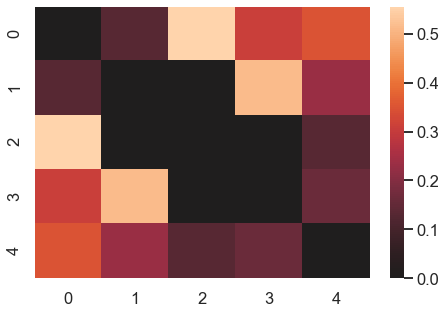

In [16]:
# Normalize A matrix and plot
u, s, vt = svd(A_lesioned) # SVD
A_norm = (A_lesioned/s[0])*c # Matrix normalization

f, ax = plt.subplots()
f.set_figwidth(7.5)
f.set_figheight(5)
sns.heatmap(A_norm, center = 0, ax = ax)

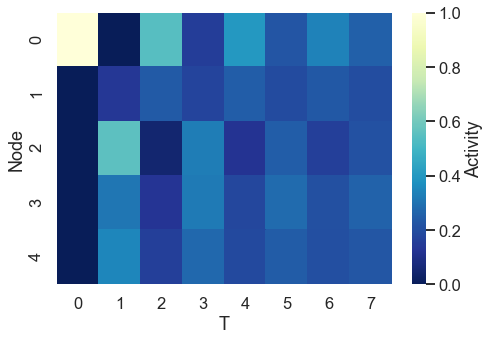

In [17]:
# Simulate linear system
x = np.zeros((num_nodes,num_steps))
x[0,0] = 1 # set region 0 to be 'on' at T 0
for t in np.arange(1,num_steps): # run simulation of linear system
    x[:,t] = np.dot(A_norm,x[:,t-1])

f, ax = plt.subplots()
f.set_figwidth(7.5)
f.set_figheight(5)
sns.heatmap(x, ax = ax, cmap = 'YlGnBu_r', cbar_kws={'label': 'Activity'})
ax.set_xlabel('T')
ax.set_ylabel('Node')
f.savefig('YlGnBu_r_lesioned.svg', dpi = 300, bbox_inches = 'tight')

# Manipulating C

The normalization constant (c) determines the value of the largest eigenvalue in the system. By convention we set to 0.99 so that it, and all subsequent modes of the system, decay over time. By decreasing c we force all the system's modes to decay more quickly and thus shorten the life of impulse response. 

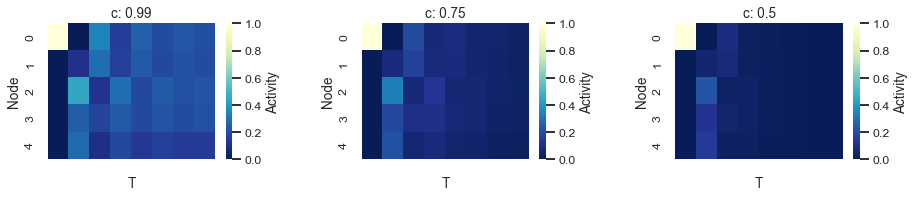

In [18]:
sns.set(style='white', context = 'talk', font_scale = 0.75)

f, ax = plt.subplots(1,3)
f.set_figwidth(15)
f.set_figheight(2.5)

u, s, vt = svd(A) # SVD

for i, c in enumerate([0.99, 0.75, 0.5]): # note, 0.99 is the default param used in all of above
    A_norm = (A/s[0])*c # Matrix normalization

    x = np.zeros((num_nodes,num_steps))
    x[0,0] = 1 # set region 0 to be 'on' at T 0
    for t in np.arange(1,num_steps): # run simulation of linear system
        x[:,t] = np.dot(A_norm,x[:,t-1])

    sns.heatmap(x, ax = ax[i], cmap = 'YlGnBu_r', cbar_kws={'label': 'Activity'})
    ax[i].set_title('c: '+str(c))
    ax[i].set_xlabel('T')
    ax[i].set_ylabel('Node')
    ax[i].set_xticklabels('')

plt.subplots_adjust(wspace=0.5)
f.savefig('YlGnBu_r_full_overc.png', dpi = 300, bbox_inches = 'tight')